In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
uwrfkaggler_ravdess_emotional_speech_audio_path = kagglehub.dataset_download('uwrfkaggler/ravdess-emotional-speech-audio')
ejlok1_toronto_emotional_speech_set_tess_path = kagglehub.dataset_download('ejlok1/toronto-emotional-speech-set-tess')
ejlok1_cremad_path = kagglehub.dataset_download('ejlok1/cremad')
ejlok1_surrey_audiovisual_expressed_emotion_savee_path = kagglehub.dataset_download('ejlok1/surrey-audiovisual-expressed-emotion-savee')

print('Data source import complete.')


Data source import complete.


In [ ]:
import pandas as pd
import numpy as np


import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import sys

# librosa is a Python library for analyzing audio and music. It can be used to extract the data from the audio files we will see it later.
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# to play the audio files
from IPython.display import Audio

import keras
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
from keras.utils import to_categorical

from keras.callbacks import ModelCheckpoint

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [ ]:
# Paths for data.
Ravdess = "/kaggle/input/ravdess-emotional-speech-audio/audio_speech_actors_01-24/"
Crema = "/kaggle/input/cremad/AudioWAV/"
Tess = "/kaggle/input/toronto-emotional-speech-set-tess/tess toronto emotional speech set data/TESS Toronto emotional speech set data/"
Savee = "/kaggle/input/surrey-audiovisual-expressed-emotion-savee/ALL/"

In [ ]:
ravdess_directory_list = os.listdir(Ravdess)

file_emotion = []
file_path = []
for dir in ravdess_directory_list:
    # as their are 20 different actors in our previous directory we need to extract files for each actor.
    actor = os.listdir(Ravdess + dir)
    for file in actor:
        part = file.split('.')[0]
        part = part.split('-')
        # third part in each file represents the emotion associated to that file.
        file_emotion.append(int(part[2]))
        file_path.append(Ravdess + dir + '/' + file)
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Ravdess_df = pd.concat([emotion_df, path_df], axis=1)

# changing integers to actual emotions.
Ravdess_df.Emotions.replace({1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'}, inplace=True)
Ravdess_df.head()


<ipython-input-4-4636a5b0c4bd>:22: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  Ravdess_df.Emotions.replace({1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'}, inplace=True)


Emotions                                               Path
0  surprise  /kaggle/input/ravdess-emotional-speech-audio/a...
1   neutral  /kaggle/input/ravdess-emotional-speech-audio/a...
2   disgust  /kaggle/input/ravdess-emotional-speech-audio/a...
3   disgust  /kaggle/input/ravdess-emotional-speech-audio/a...
4   neutral  /kaggle/input/ravdess-emotional-speech-audio/a...

In [ ]:
crema_directory_list = os.listdir(Crema)

file_emotion = []
file_path = []

for file in crema_directory_list:
    # storing file paths
    file_path.append(Crema + file)
    # storing file emotions
    part=file.split('_')
    if part[2] == 'SAD':
        file_emotion.append('sad')
    elif part[2] == 'ANG':
        file_emotion.append('angry')
    elif part[2] == 'DIS':
        file_emotion.append('disgust')
    elif part[2] == 'FEA':
        file_emotion.append('fear')
    elif part[2] == 'HAP':
        file_emotion.append('happy')
    elif part[2] == 'NEU':
        file_emotion.append('neutral')
    else:
        file_emotion.append('Unknown')

# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Crema_df = pd.concat([emotion_df, path_df], axis=1)
Crema_df.head()


Emotions                                               Path
0  disgust  /kaggle/input/cremad/AudioWAV/1028_TSI_DIS_XX.wav
1    happy  /kaggle/input/cremad/AudioWAV/1075_IEO_HAP_LO.wav
2    happy  /kaggle/input/cremad/AudioWAV/1084_ITS_HAP_XX.wav
3  disgust  /kaggle/input/cremad/AudioWAV/1067_IWW_DIS_XX.wav
4  disgust  /kaggle/input/cremad/AudioWAV/1066_TIE_DIS_XX.wav

In [ ]:
tess_directory_list = os.listdir(Tess)

file_emotion = []
file_path = []

for dir in tess_directory_list:
    directories = os.listdir(Tess + dir)
    for file in directories:
        part = file.split('.')[0]
        part = part.split('_')[2]
        if part=='ps':
            file_emotion.append('surprise')
        else:
            file_emotion.append(part)
        file_path.append(Tess + dir + '/' + file)
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Tess_df = pd.concat([emotion_df, path_df], axis=1)
Tess_df.head()

Emotions                                               Path
0     fear  /kaggle/input/toronto-emotional-speech-set-tes...
1     fear  /kaggle/input/toronto-emotional-speech-set-tes...
2     fear  /kaggle/input/toronto-emotional-speech-set-tes...
3     fear  /kaggle/input/toronto-emotional-speech-set-tes...
4     fear  /kaggle/input/toronto-emotional-speech-set-tes...

In [ ]:
savee_directory_list = os.listdir(Savee)

file_emotion = []
file_path = []

for file in savee_directory_list:
    file_path.append(Savee + file)
    part = file.split('_')[1]
    ele = part[:-6]
    if ele=='a':
        file_emotion.append('angry')
    elif ele=='d':
        file_emotion.append('disgust')
    elif ele=='f':
        file_emotion.append('fear')
    elif ele=='h':
        file_emotion.append('happy')
    elif ele=='n':
        file_emotion.append('neutral')
    elif ele=='sa':
        file_emotion.append('sad')
    else:
        file_emotion.append('surprise')

# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Savee_df = pd.concat([emotion_df, path_df], axis=1)
Savee_df.head()

Emotions                                               Path
0    happy  /kaggle/input/surrey-audiovisual-expressed-emo...
1     fear  /kaggle/input/surrey-audiovisual-expressed-emo...
2    happy  /kaggle/input/surrey-audiovisual-expressed-emo...
3  disgust  /kaggle/input/surrey-audiovisual-expressed-emo...
4    angry  /kaggle/input/surrey-audiovisual-expressed-emo...

In [ ]:
# creating Dataframe using all the 4 dataframes we created so far.
data_path = pd.concat([Ravdess_df, Crema_df, Tess_df, Savee_df], axis = 0)
data_path.to_csv("data_path.csv",index=False)
data_path.head()

Emotions                                               Path
0  surprise  /kaggle/input/ravdess-emotional-speech-audio/a...
1   neutral  /kaggle/input/ravdess-emotional-speech-audio/a...
2   disgust  /kaggle/input/ravdess-emotional-speech-audio/a...
3   disgust  /kaggle/input/ravdess-emotional-speech-audio/a...
4   neutral  /kaggle/input/ravdess-emotional-speech-audio/a...

In [ ]:
print(data_path.shape)  # Number of rows and columns
print(data_path['Emotions'].value_counts())  # Distribution per class
print(data_path.isnull().sum())  # Missing values?


(12162, 2)
Emotions
fear        1923
disgust     1923
happy       1923
sad         1923
angry       1923
neutral     1703
surprise     652
calm         192
Name: count, dtype: int64
Emotions    0
Path        0
dtype: int64


<ipython-input-9-a6ce375b4ed7>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=emotion_counts.index, y=emotion_counts.values, palette='Set2')


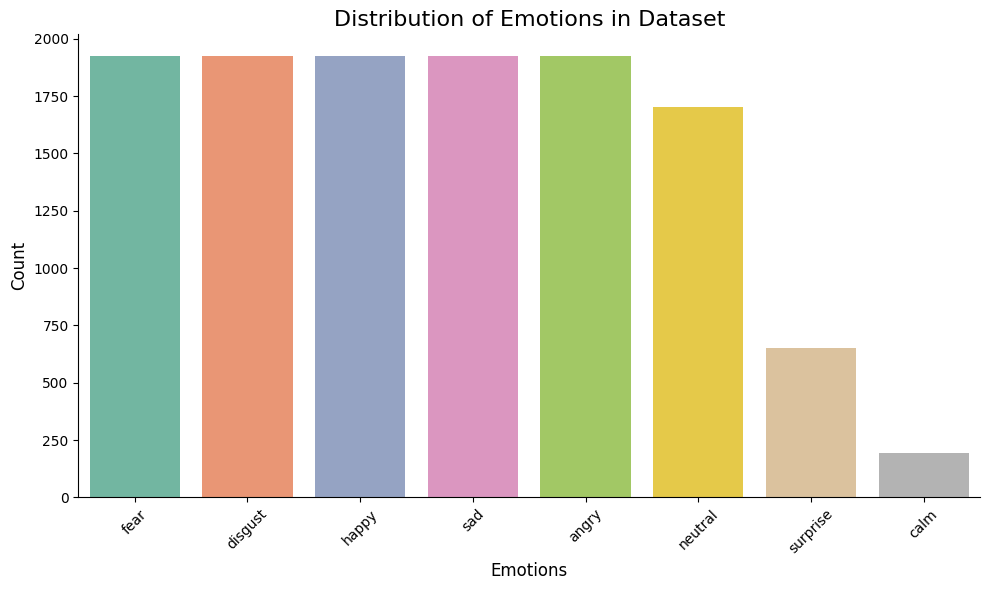

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Count the emotion labels
emotion_counts = data_path['Emotions'].value_counts().sort_values(ascending=False)

# Set figure size
plt.figure(figsize=(10, 6))

# Create bar plot
sns.barplot(x=emotion_counts.index, y=emotion_counts.values, palette='Set2')

# Titles and labels
plt.title('Distribution of Emotions in Dataset', fontsize=16)
plt.xlabel('Emotions', fontsize=12)
plt.ylabel('Count', fontsize=12)

# Optional: rotate x-axis labels for readability
plt.xticks(rotation=45)

# Remove top and right spines for cleaner look
sns.despine()

# Display plot
plt.tight_layout()
plt.show()


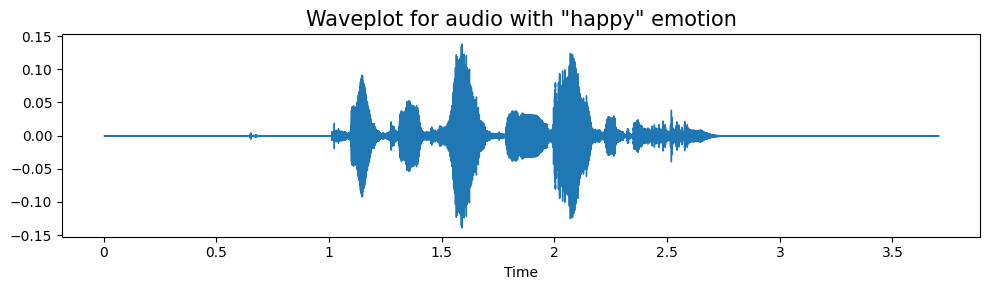

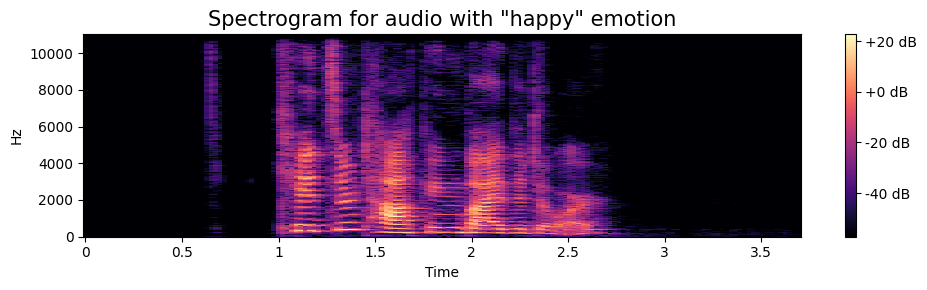

In [ ]:
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
from IPython.display import Audio

# Function to create a waveform plot
def create_waveplot(data, sr, e):
    plt.figure(figsize=(10, 3))
    plt.title(f'Waveplot for audio with "{e}" emotion', size=15)
    librosa.display.waveshow(data, sr=sr)
    plt.tight_layout()
    plt.show()

# Function to create a spectrogram
def create_spectrogram(data, sr, e):
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(np.abs(X))
    plt.figure(figsize=(10, 3))
    plt.title(f'Spectrogram for audio with "{e}" emotion', size=15)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
    plt.colorbar(format='%+2.0f dB')
    plt.tight_layout()
    plt.show()

# Pick an emotion to visualize
emotion = 'happy'  # Change to 'sad', 'angry', etc.

# Pick one sample for that emotion
path = np.array(data_path.Path[data_path.Emotions == emotion])[1]

# Load the audio file
data, sampling_rate = librosa.load(path)

# Plot waveplot
create_waveplot(data, sampling_rate, emotion)

# Plot spectrogram
create_spectrogram(data, sampling_rate, emotion)

# Optionally play the audio
Audio(path)


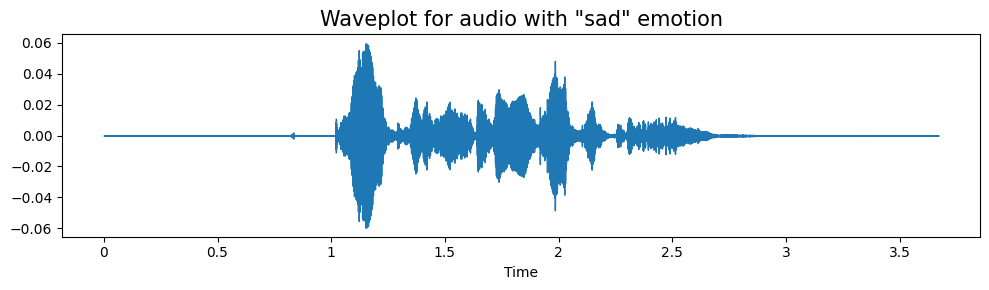

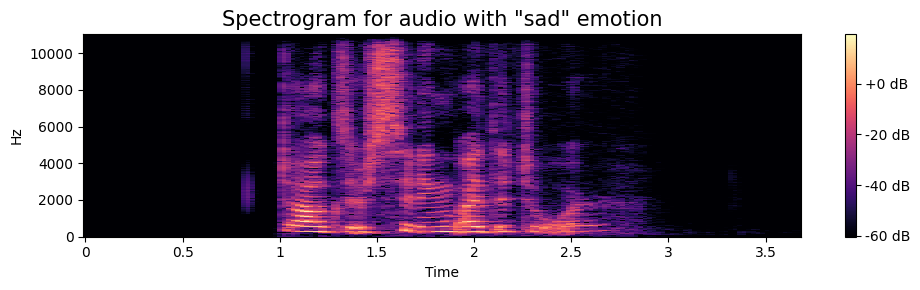

In [ ]:
emotion = 'sad'  # Change to 'sad', 'angry', etc.

# Pick one sample for that emotion
path = np.array(data_path.Path[data_path.Emotions == emotion])[1]

# Load the audio file
data, sampling_rate = librosa.load(path)

# Plot waveplot
create_waveplot(data, sampling_rate, emotion)

# Plot spectrogram
create_spectrogram(data, sampling_rate, emotion)

# Optionally play the audio
Audio(path)

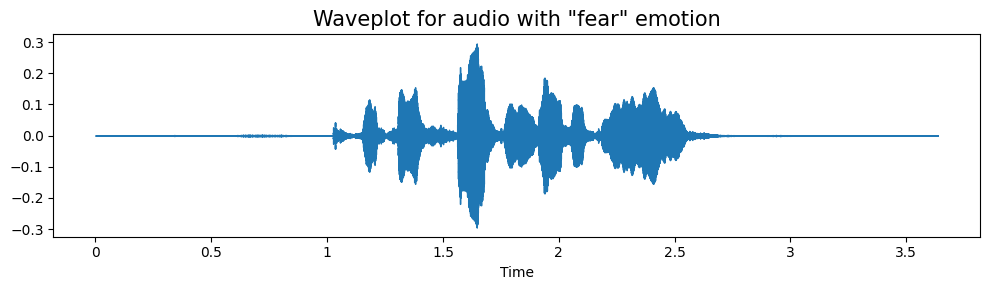

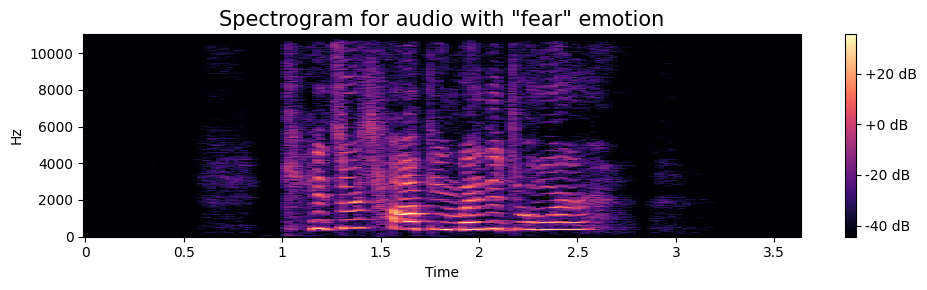

In [ ]:
emotion = 'fear'  # Change to 'sad', 'angry', etc.

# Pick one sample for that emotion
path = np.array(data_path.Path[data_path.Emotions == emotion])[1]

# Load the audio file
data, sampling_rate = librosa.load(path)

# Plot waveplot
create_waveplot(data, sampling_rate, emotion)

# Plot spectrogram
create_spectrogram(data, sampling_rate, emotion)

# Optionally play the audio
Audio(path)

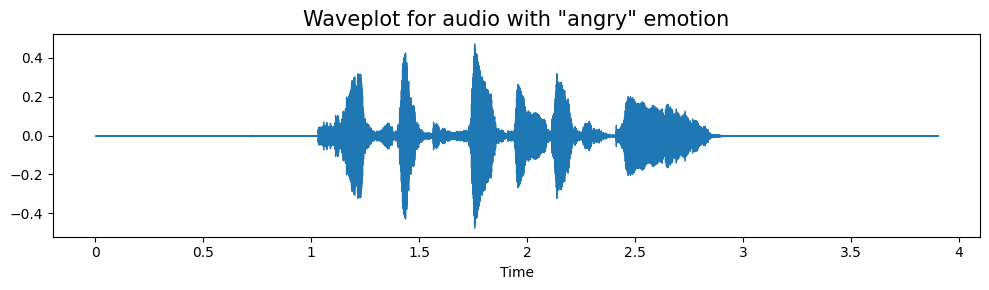

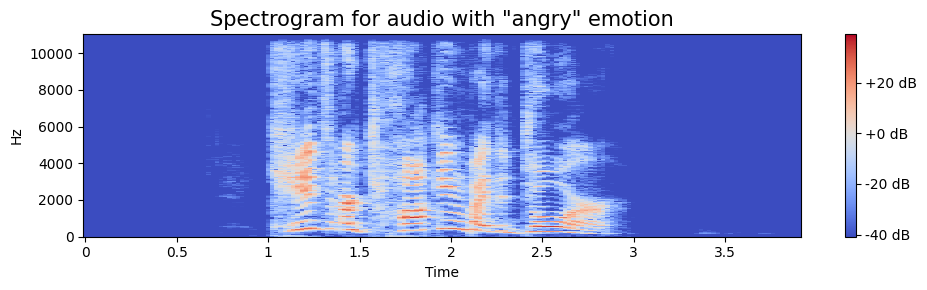

In [ ]:
emotion = 'angry'  # Change to 'sad', 'angry', etc.

# Pick one sample for that emotion
path = np.array(data_path.Path[data_path.Emotions == emotion])[1]

# Load the audio file
data, sampling_rate = librosa.load(path)

# Plot waveplot
create_waveplot(data, sampling_rate, emotion)

# Plot spectrogram
create_spectrogram(data, sampling_rate, emotion)

# Optionally play the audio
Audio(path)

Data Augmentation


In [ ]:

def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(y= data, rate = rate)

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sampling_rate, pitch_factor)

# taking any example and checking for techniques.
path = np.array(data_path.Path)[1]
data, sample_rate = librosa.load(path)

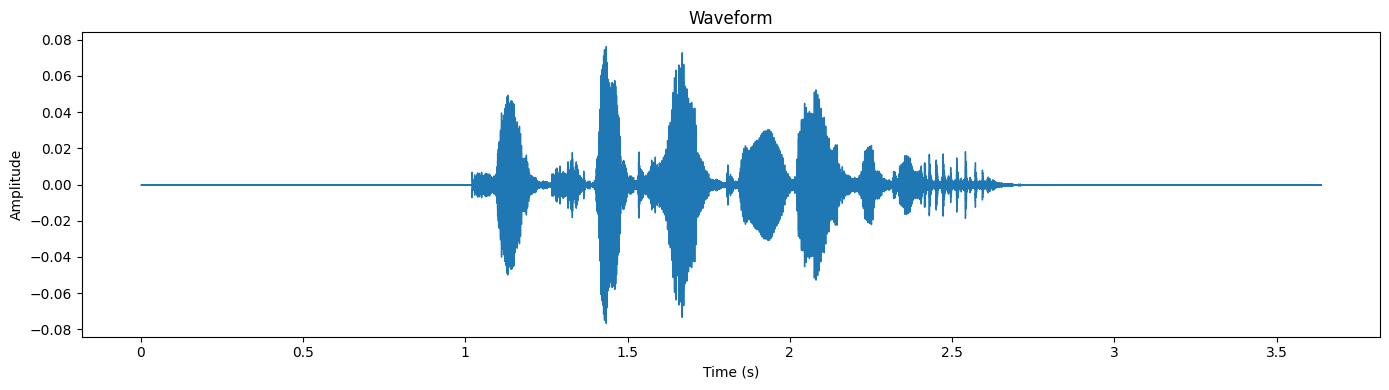

In [ ]:
# Plot the waveform
plt.figure(figsize=(14, 4))
librosa.display.waveshow(y=data, sr=sample_rate)
plt.title('Waveform')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.tight_layout()
plt.show()

# Play the audio
Audio(path)


Noise Injection


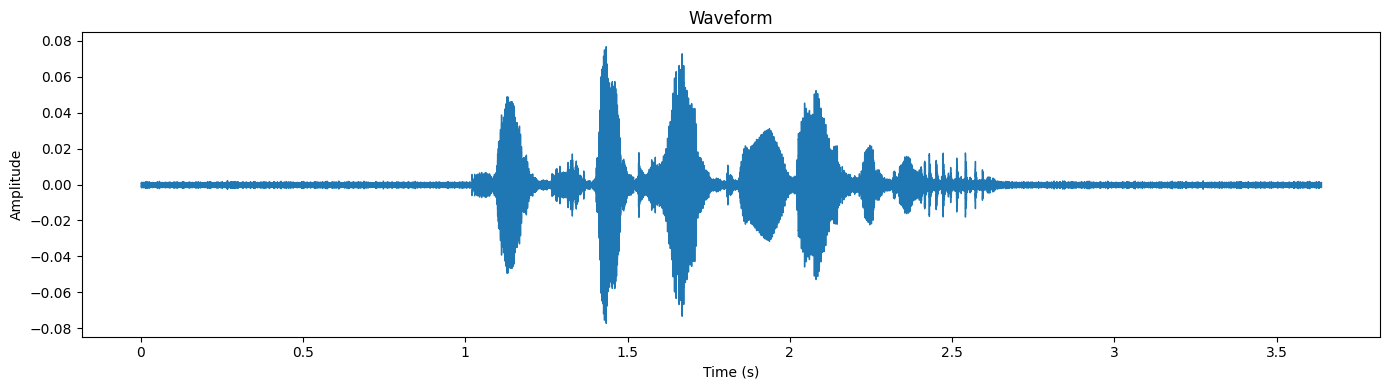

In [ ]:
x = noise(data)
# Plot the waveform
plt.figure(figsize=(14, 4))
librosa.display.waveshow(y=x, sr=sample_rate)
plt.title('Waveform')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.tight_layout()
plt.show()

# Play the audio
Audio(x, rate= sample_rate)

Stretching

In [1]:
x= stretch(data)
plt.figure(figsize=(14, 4))
librosa.display.waveshow(y=x, sr=sample_rate)
plt.title('Waveform')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.tight_layout()
plt.show()

# Play the audio
Audio(x, rate = sample_rate)

NameError: name 'stretch' is not defined

Shifting

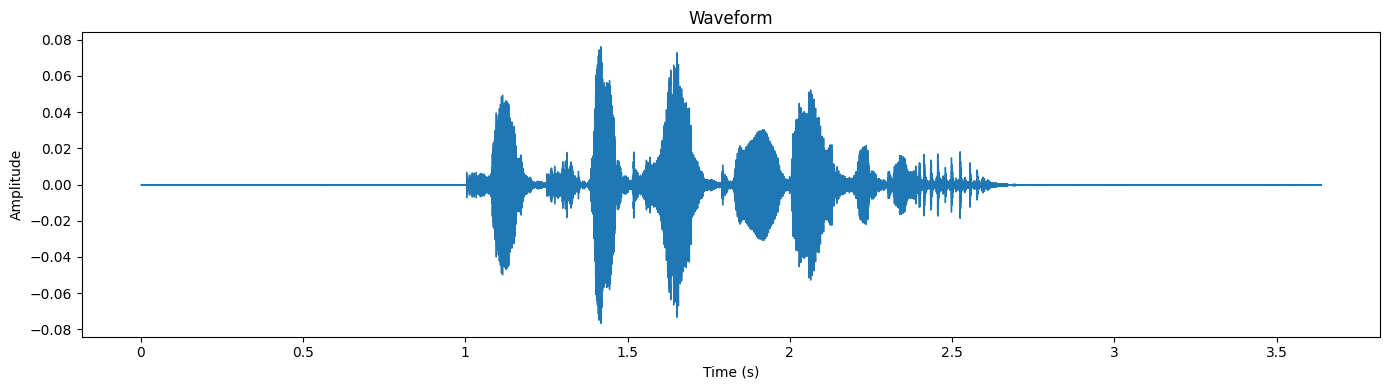

In [ ]:
x= shift(data)
plt.figure(figsize=(14, 4))
librosa.display.waveshow(y=x, sr=sample_rate)
plt.title('Waveform')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.tight_layout()
plt.show()

# Play the audio
Audio(x, rate = sample_rate)

Pitch

In [ ]:

def pitch(data, sample_rate, n_steps=2):
    """
    Shifts the pitch of the audio.

    Parameters:
        data: np.ndarray — The audio time-series.
        sample_rate: int — The sampling rate of the audio.
        n_steps: int — Number of half-steps to shift. (+ for higher pitch, - for lower)

    Returns:
        np.ndarray — The pitch-shifted audio.
    """
    return librosa.effects.pitch_shift(y=data, sr=sample_rate, n_steps=n_steps)


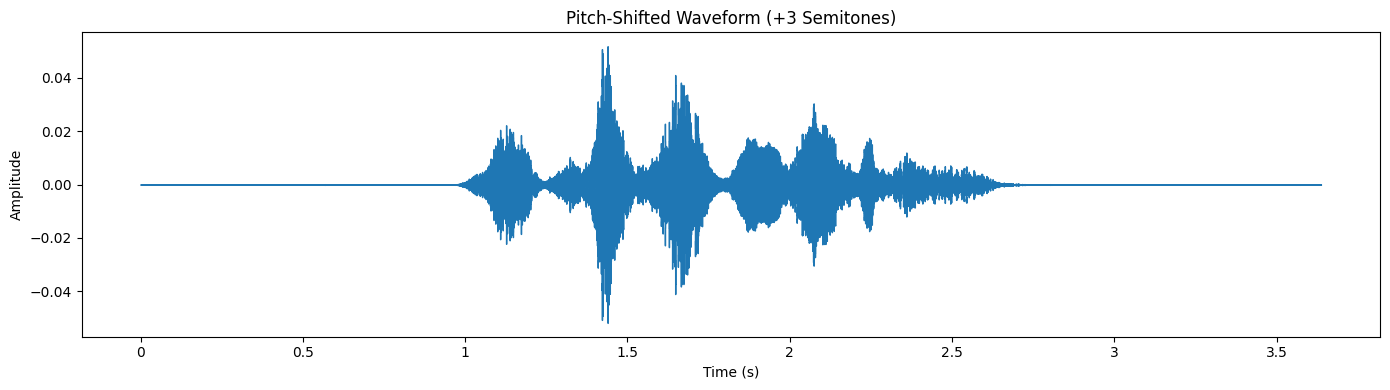

In [ ]:
# Shift pitch up by 3 semitones
y_pitch = pitch(data, sample_rate, n_steps=3)

# Plot the pitch-shifted waveform
plt.figure(figsize=(14, 4))
librosa.display.waveshow(y=y_pitch, sr=sample_rate)
plt.title('Pitch-Shifted Waveform (+3 Semitones)')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.tight_layout()
plt.show()

# Play it (in Jupyter/Colab)
Audio(y_pitch, rate=sample_rate)


Feature extraction

In [ ]:
def extract_features(data):
    # ZCR
    result = np.array([])
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result=np.hstack((result, zcr)) # stacking horizontally

    # Chroma_stft
    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    result = np.hstack((result, chroma_stft)) # stacking horizontally

    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mfcc)) # stacking horizontally

    # Root Mean Square Value
    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    result = np.hstack((result, rms)) # stacking horizontally

    # MelSpectogram
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mel)) # stacking horizontally

    return result

def get_features(path):
    # duration and offset are used to take care of the no audio in start and the ending of each audio files as seen above.
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)

    # without augmentation
    res1 = extract_features(data)
    result = np.array(res1)

    # data with noise
    noise_data = noise(data)
    res2 = extract_features(noise_data)
    result = np.vstack((result, res2)) # stacking vertically

    # data with stretching and pitching
    new_data = stretch(data)
    data_stretch_pitch = pitch(new_data, sample_rate)
    res3 = extract_features(data_stretch_pitch)
    result = np.vstack((result, res3)) # stacking vertically

    return result

In [ ]:
X, Y = [], []
for path, emotion in zip(data_path.Path, data_path.Emotions):
    feature = get_features(path)
    for ele in feature:
        X.append(ele)
        # appending emotion 3 times as we have made 3 augmentation techniques on each audio file.
        Y.append(emotion)

In [ ]:
len(X), len(Y), data_path.Path.shape

In [ ]:
Features = pd.DataFrame(X)
Features['labels'] = Y
Features.to_csv('features.csv', index=False)
Features.head()

Data Preparation

In [ ]:
X = Features.iloc[: ,:-1].values
Y = Features['labels'].values

In [ ]:
# As this is a multiclass classification problem onehotencoding our Y.
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

In [ ]:
# splitting data
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=0, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

In [ ]:
# scaling our data with sklearn's Standard scaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

In [ ]:
# making our data compatible to model.
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

Modelling

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dropout, Flatten, Dense, BatchNormalization

model = Sequential()

# 1st Convolution Block
model.add(Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(x_train.shape[1], 1)))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2, strides=2, padding='same'))

# 2nd Convolution Block
model.add(Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2, strides=2, padding='same'))

# 3rd Convolution Block
model.add(Conv1D(64, kernel_size=3, strides=1, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2, strides=2, padding='same'))
model.add(Dropout(0.3))

# 4th Convolution Block
model.add(Conv1D(32, kernel_size=3, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2, strides=2, padding='same'))

# Flatten & Dense Layers
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.4))

# Output Layer (for 8 classes)
model.add(Dense(8, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Summary
model.summary()


In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

# Callback to reduce learning rate on plateau
rlrp = ReduceLROnPlateau(
    monitor='val_loss',   # Better to monitor validation loss
    factor=0.5,           # Reduce LR by a factor of 0.5
    patience=3,           # Wait 3 epochs before reducing LR
    verbose=1,            # Print when LR is reduced
    min_lr=1e-6           # Lower bound for LR
)

# Fit the model
history = model.fit(
    x_train, y_train,
    batch_size=32,             # Reduced for finer gradient updates
    epochs=30,                 # Reduced for quicker experimentation
    validation_data=(x_test, y_test),
    callbacks=[rlrp]
)


Epoch 1/30
856/856 ━━━━━━━━━━━━━━━━━━━━ 76s 83ms/step - accuracy: 0.3051 - loss: 1.7771 - val_accuracy: 0.4600 - val_loss: 1.3780 - learning_rate: 0.0010
Epoch 2/30
856/856 ━━━━━━━━━━━━━━━━━━━━ 72s 84ms/step - accuracy: 0.4283 - loss: 1.4299 - val_accuracy: 0.4934 - val_loss: 1.2607 - learning_rate: 0.0010
Epoch 3/30
856/856 ━━━━━━━━━━━━━━━━━━━━ 85s 88ms/step - accuracy: 0.4668 - loss: 1.3244 - val_accuracy: 0.5053 - val_loss: 1.2100 - learning_rate: 0.0010
Epoch 4/30
856/856 ━━━━━━━━━━━━━━━━━━━━ 71s 83ms/step - accuracy: 0.4853 - loss: 1.2807 - val_accuracy: 0.5221 - val_loss: 1.1676 - learning_rate: 0.0010
Epoch 5/30
856/856 ━━━━━━━━━━━━━━━━━━━━ 82s 84ms/step - accuracy: 0.4966 - loss: 1.2451 - val_accuracy: 0.5351 - val_loss: 1.1423 - learning_rate: 0.0010
Epoch 6/30
856/856 ━━━━━━━━━━━━━━━━━━━━ 70s 82ms/step - accuracy: 0.5178 - loss: 1.2092 - val_accuracy: 0.5418 - val_loss: 1.1390 - learning_rate: 0.0010
Epoch 7/30
856/856 ━━━━━━━━━━━━━━━━━━━━ 83s 83ms/step - accuracy: 0.5194 - l

286/286 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.6172 - loss: 0.9841
Accuracy of our model on test data :  61.20368242263794 %


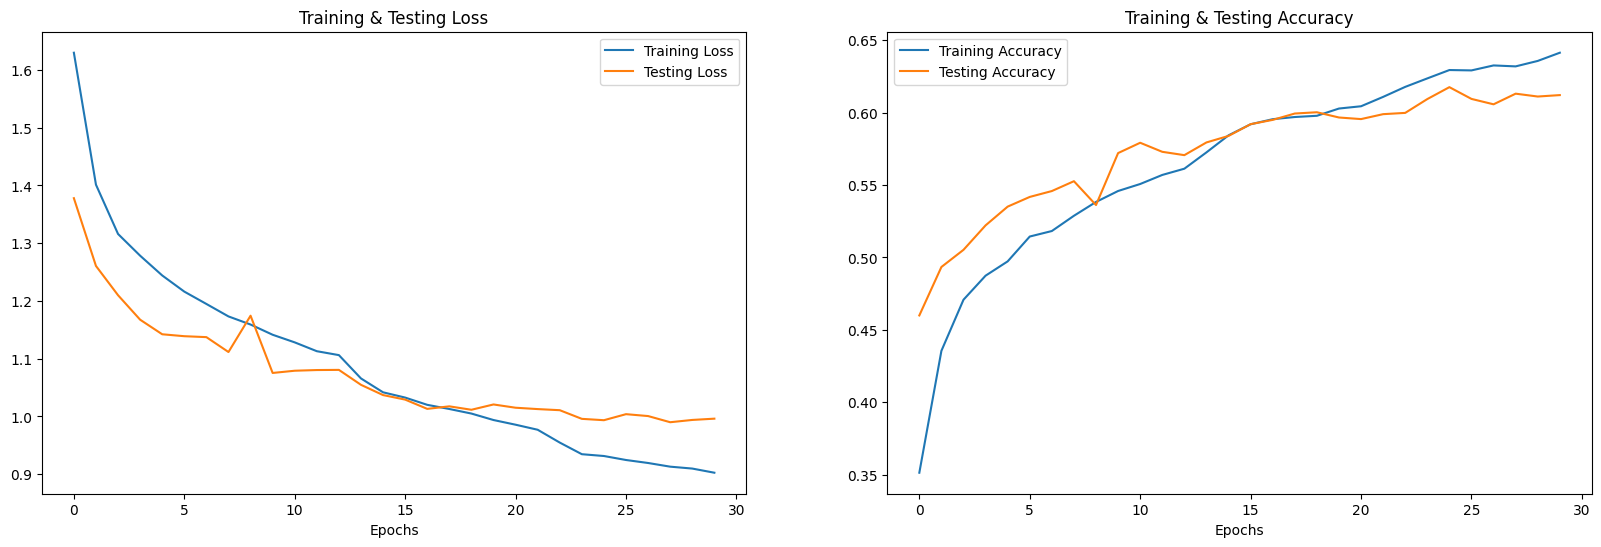

In [ ]:
print("Accuracy of our model on test data : " , model.evaluate(x_test,y_test)[1]*100 , "%")

epochs = [i for i in range(30)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']
fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()


In [ ]:
# predicting on test data.
pred_test = model.predict(x_test)
y_pred = encoder.inverse_transform(pred_test)

y_test = encoder.inverse_transform(y_test)

286/286 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step


In [ ]:
df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_test.flatten()

df.head(10)

Predicted Labels Actual Labels
0          disgust       disgust
1          neutral       neutral
2             fear          fear
3            happy         angry
4            happy          fear
5          disgust       disgust
6            angry         angry
7          disgust       disgust
8             fear       disgust
9          neutral       neutral

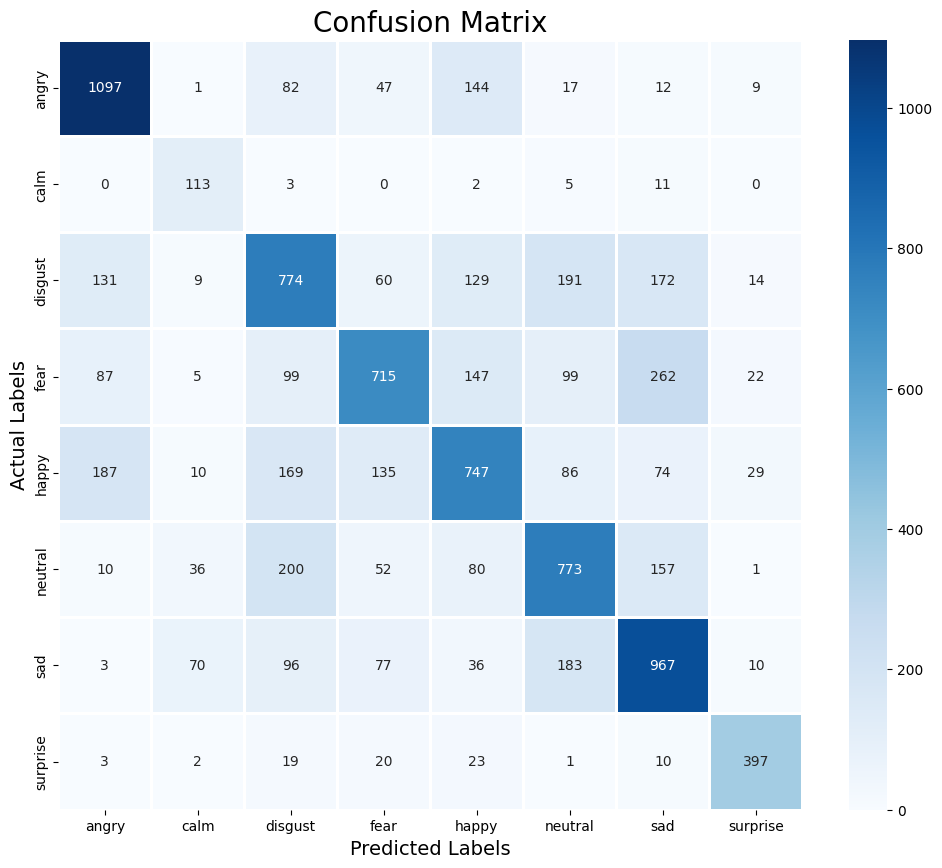

In [ ]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       angry       0.72      0.78      0.75      1409
        calm       0.46      0.84      0.59       134
     disgust       0.54      0.52      0.53      1480
        fear       0.65      0.50      0.56      1436
       happy       0.57      0.52      0.54      1437
     neutral       0.57      0.59      0.58      1309
         sad       0.58      0.67      0.62      1442
    surprise       0.82      0.84      0.83       475

    accuracy                           0.61      9122
   macro avg       0.61      0.66      0.63      9122
weighted avg       0.61      0.61      0.61      9122



In [ ]:
model.save('my_model.h5')


In [ ]:
model.save('my_model.keras')

In [ ]:
from google.colab import files
files.download('my_model.keras')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from google.colab import files
files.download('my_model.h5')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>